## <font color='darkblue'>Introduction</font>
([Article source](https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1), [notebook source](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Anomaly_Detection_for_Dummies.ipynb)) [**Anomaly detection**](https://en.wikipedia.org/wiki/Anomaly_detection) is the process of identifying unexpected items or events in data sets, which differ from the norm. And anomaly detection is often applied on unlabeled data which is known as unsupervised anomaly detection. Anomaly detection has two basic assumptions:
* Anomalies only occur very rarely in the data.
* Their features differ from the normal instances significantly.

### <font color='darkgreen'>Agenda</font>
* [**Univariate Anomaly Detection**](#sect1)
* [**Multivariate Anomaly Detection**](#sect2)
    * [Cluster-based Local Outlier Factor (CBLOF)](#sect2_1)
    * [Histogram-based Outlier Detection (HBOS)](#sect2_2)
    * [Isolation Forest](#sect2_3)
    * [K - Nearest Neighbors (KNN)](#sect2_4)
    * [Visually investigate some of the anomalies](#sect2_5)

<a id='sect1'></a>
## <font color='darkblue'>Univariate Anomaly Detection</font>
Before we get to Multivariate anomaly detection, I think its necessary to work through a simple example of Univariate anomaly detection method in which we detect outliers from a distribution of values in a single feature space.

We are using the [Super Store Sales data set](https://community.tableau.com/docs/DOC-1236) that can be downloaded from [here](https://community.tableau.com/docs/DOC-1236), and **we are going to find patterns in Sales and Profit separately that do not conform to expected behavior. That is, spotting outliers for one variable at a time.**

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from numpy import percentile
from sklearn.ensemble import IsolationForest
from scipy.stats import norm
from pyod.models.cblof import CBLOF
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from sklearn.preprocessing import MinMaxScaler

### <font color='darkgreen'>Distribution of the Sales</font>

In [2]:
df = pd.read_excel("../../datas/sample_superstore.xls")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
df['Sales'].describe()

count     9994.000000
mean       229.858001
std        623.245101
min          0.444000
25%         17.280000
50%         54.490000
75%        209.940000
max      22638.480000
Name: Sales, dtype: float64

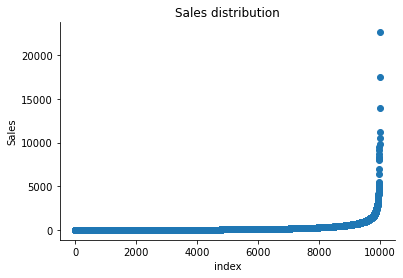

In [4]:
plt.scatter(range(df.shape[0]), np.sort(df['Sales'].values))
plt.xlabel('index')
plt.ylabel('Sales')
plt.title("Sales distribution")
sns.despine()

Text(0.5, 6.79999999999999, 'Sales')

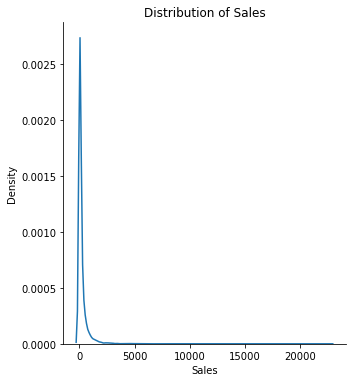

In [5]:
ax = sns.displot(df['Sales'].to_numpy(), kind="kde")
plt.title("Distribution of Sales")
plt.xlabel("Sales")
# sns.despine()

**The Superstore’s sales distribution is far from a normal distribution, and it has a positive long thin tail, the mass of the distribution is concentrated on the left of the figure**. And the tail sales distribution far exceeds the tails of the normal distribution.

There are one region where the data has low probability to appear which is on the right side of the distribution.

### <font color='darkgreen'>Distribution of the Profit</font>

In [6]:
df['Profit'].describe()

count    9994.000000
mean       28.656896
std       234.260108
min     -6599.978000
25%         1.728750
50%         8.666500
75%        29.364000
max      8399.976000
Name: Profit, dtype: float64

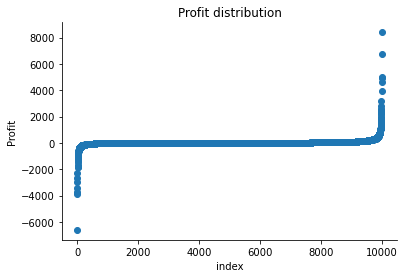

In [7]:
plt.scatter(range(df.shape[0]), np.sort(df['Profit'].values))
plt.xlabel('index')
plt.ylabel('Profit')
plt.title("Profit distribution")
sns.despine()

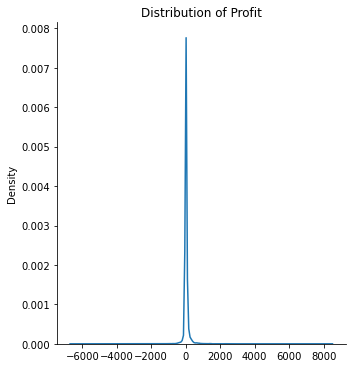

In [8]:
sns.displot(df['Profit'].to_numpy(), kind="kde")
plt.title("Distribution of Profit")
sns.despine()

For [**Skewness**](https://en.wikipedia.org/wiki/Skewness) and [**Kurtosis**](https://en.wikipedia.org/wiki/Kurtosis) analysis:
* The kurtosis of any univariate normal distribution is 3. It is common to compare the kurtosis of a distribution to this value.

In [9]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.skew.html
print("Skewness: %f" % df['Profit'].skew())

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.kurt.html
print("Kurtosis: %f" % df['Profit'].kurt())

Skewness: 7.561432
Kurtosis: 397.188515


The Superstore’s Profit distribution has both a positive tail and negative tail. However, the positive tail is longer than the negative tail. So the distribution is positive skewed, and the data are heavy-tailed or profusion of outliers.

There are two regions where the data has low probability to appear: one on the right side of the distribution, another one on the left.

### <font color='darkgreen'>Univariate Anomaly Detection on Sales</font>
[**Isolation Forest**](https://en.wikipedia.org/wiki/Isolation_forest) **is an algorithm to detect outliers that returns the anomaly score of each sample using the IsolationForest algorithm which is based on the fact that anomalies are data points that are few and different**. Isolation Forest is a tree-based model. In these trees, partitions are created by first randomly selecting a feature and then selecting a random split value between the minimum and maximum value of the selected feature.

The following process shows how IsolationForest behaves in the case of the Susperstore’s sales, and the algorithm was implemented in Sklearn and the code was largely borrowed from [this tutorial](https://dzone.com/articles/spotting-outliers-with-isolation-forest-using-skle):
* Trained [**IsolationForest**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) using the Sales data.
* Store the Sales in the NumPy array for using in our models later.
* Computed the anomaly score for each observation. The anomaly score of an input sample is computed as the mean anomaly score of the trees in the forest.
* Classified each observation as an outlier or non-outlier.
* The visualization highlights the regions where the outliers fall.

In [10]:
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df['Sales'].values.reshape(-1, 1))

IsolationForest()

In [11]:
xx = np.linspace(df['Sales'].min(), df['Sales'].max(), len(df)).reshape(-1,1)
print(xx.shape)
xx

(9994, 1)


array([[4.44000000e-01],
       [2.70938937e+00],
       [4.97477875e+00],
       ...,
       [2.26339492e+04],
       [2.26362146e+04],
       [2.26384800e+04]])

In [12]:
xx.T[0].shape

(9994,)

In [13]:
anomaly_score = isolation_forest.decision_function(xx)
print(anomaly_score.shape)
anomaly_score

(9994,)


array([ 0.02611602,  0.05863163,  0.09775653, ..., -0.37048897,
       -0.37048897, -0.37048897])

In [14]:
outlier = isolation_forest.predict(xx)
for is_outliner, sale in zip(outlier, xx.T[0]):
    if is_outliner == -1:
        print(f"sale after {sale} will be predicted as outliner!")
        break    

sale after 353.84474211948367 will be predicted as outliner!


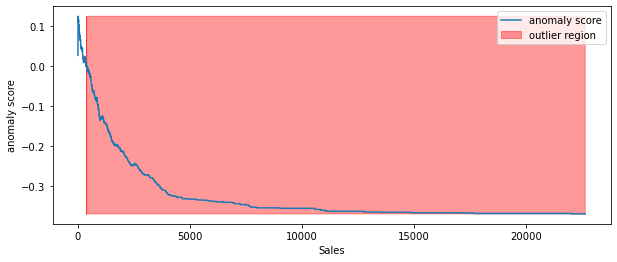

In [15]:
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Sales')
plt.show();

According to the above results and visualization, It seems that **Sales that exceeds 329 would be definitely considered as an outlier.**

### <font color='green'>Visually investigate one anomaly</font>

In [16]:
df.iloc[10]

Row ID                                                 11
Order ID                                   CA-2014-115812
Order Date                            2014-06-09 00:00:00
Ship Date                             2014-06-14 00:00:00
Ship Mode                                  Standard Class
Customer ID                                      BH-11710
Customer Name                             Brosina Hoffman
Segment                                          Consumer
Country                                     United States
City                                          Los Angeles
State                                          California
Postal Code                                         90032
Region                                               West
Product ID                                FUR-TA-10001539
Category                                        Furniture
Sub-Category                                       Tables
Product Name     Chromcraft Rectangular Conference Tables
Sales         

This purchase seems normal to me expect it was a larger amount of sales compared with the other orders in the data.

### <font color='darkgreen'>Univariate Anomaly Detection on Profit</font>
* Trained IsolationForest using the Profit variable.
* Store the Profit in the NumPy array for using in our models later.
* Computed the anomaly score for each observation. The anomaly score of an input sample is computed as the mean anomaly score of the trees in the forest.
* Classified each observation as an outlier or non-outlier.
* The visualization highlights the regions where the outliers fall.

In [17]:
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df['Profit'].values.reshape(-1, 1))

IsolationForest()

In [18]:
xx = np.linspace(df['Profit'].min(), df['Profit'].max(), len(df)).reshape(-1,1)
xx

array([[-6599.978     ],
       [-6598.47695387],
       [-6596.97590774],
       ...,
       [ 8396.97390774],
       [ 8398.47495387],
       [ 8399.976     ]])

In [19]:
anomaly_score = isolation_forest.decision_function(xx)
anomaly_score

array([-0.33022275, -0.33022275, -0.33022275, ..., -0.32966123,
       -0.32966123, -0.32966123])

In [20]:
outlier = isolation_forest.predict(xx)
normals = []
for is_outliner, profit in zip(outlier, xx.T[0]):
    if is_outliner > 0:
        normals.append(profit)
        
print("profit from {} to {} is normal!".format(min(normals), max(normals)))

profit from -47.91163254278126 to 118.70448814169777 is normal!


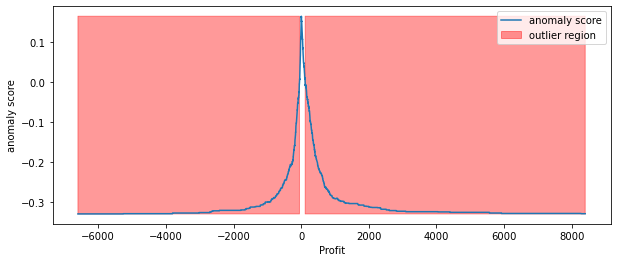

In [21]:
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Profit')
plt.show();

### <font color='darkgreen'>Visually investigate some of the anomalies</font>
According to the above results and visualization, It seems that Profit that below -64 or exceeds 144 would be considered as an outlier, let’s visually examine one example each that determined by our model and to see whether they make sense.

In [22]:
df.iloc[3]

Row ID                                                       4
Order ID                                        US-2015-108966
Order Date                                 2015-10-11 00:00:00
Ship Date                                  2015-10-18 00:00:00
Ship Mode                                       Standard Class
Customer ID                                           SO-20335
Customer Name                                   Sean O'Donnell
Segment                                               Consumer
Country                                          United States
City                                           Fort Lauderdale
State                                                  Florida
Postal Code                                              33311
Region                                                   South
Product ID                                     FUR-TA-10000577
Category                                             Furniture
Sub-Category                                           

**Any negative profit would be an anomaly and should be further investigate**, this goes without saying

In [23]:
df.iloc[1]

Row ID                                                           2
Order ID                                            CA-2016-152156
Order Date                                     2016-11-08 00:00:00
Ship Date                                      2016-11-11 00:00:00
Ship Mode                                             Second Class
Customer ID                                               CG-12520
Customer Name                                          Claire Gute
Segment                                                   Consumer
Country                                              United States
City                                                     Henderson
State                                                     Kentucky
Postal Code                                                  42420
Region                                                       South
Product ID                                         FUR-CH-10000454
Category                                                 Furni

Our model determined that this order with a large profit is an anomaly. However, when we investigate this order, it could be just a product that has a relatively high margin.

The above two visualizations show the anomaly scores and highlighted the regions where the outliers are. As expected, **the anomaly score reflects the shape of the underlying distribution and the outlier regions correspond to low probability areas.**

However, Univariate analysis can only get us thus far. We may realize that some of these anomalies that determined by our models are not the anomalies we expected. **When our data is multidimensional as opposed to univariate, the approaches to anomaly detection become more computationally intensive and more mathematically complex.**

<a id='sect2'></a>
## <font color='darkblue'>Multivariate Anomaly Detection</font>
Most of the analysis that we end up doing are multivariate due to complexity of the world we are living in. In multivariate anomaly detection, outlier is a combined unusual score on at least two variables.

So, using the `Sales` and `Profit` variables, we are going to build an unsupervised multivariate anomaly detection method based on several models. We are using [**PyOD**](https://pyod.readthedocs.io/en/latest/) which is a Python library for detecting anomalies in multivariate data. The library was developed by [Yue Zhao](https://www.yuezhao.me/).

### <font color='darkgreen'>Sales & Profit</font>
When we are in business, **we expect that Sales & Profit are positive correlated**. **If some of the Sales data points and Profit data points are not positive correlated, they would be considered as outliers and need to be further investigated**.

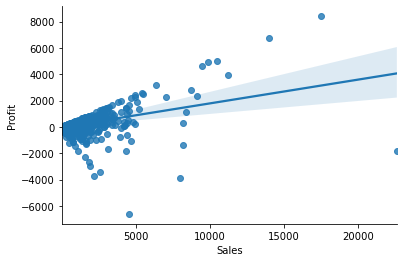

In [24]:
sns.regplot(x="Sales", y="Profit", data=df)
sns.despine();

From the above correlation chart, we can see that some of the data points are obvious outliers such as extreme low and extreme high values.

<a id='sect2_1'></a>
### <font color='darkgreen'>Cluster-based Local Outlier Factor (CBLOF)</font>
**The CBLOF calculates the outlier score based on cluster-based local outlier factor**. An anomaly score is computed by the distance of each instance to its cluster center multiplied by the instances belonging to its cluster. [PyOD library](https://pyod.readthedocs.io/en/latest/index.html) includes the [CBLOF implementation](https://pyod.readthedocs.io/en/latest/pyod.models.html#module-pyod.models.cblof).

The following code are borrowed from [PyOD tutorial](https://github.com/yzhao062/pyod/blob/master/notebooks/Compare%20All%20Models.ipynb) combined with [this article](https://www.analyticsvidhya.com/blog/2019/02/outlier-detection-python-pyod/):
* Scaling `Sales` and `Profit` to between zero and one.
* Arbitrarily set outliers fraction as 1% based on trial and best guess.
* Fit the data to the CBLOF model and predict the results.
* Use threshold value to consider a data point is inlier or outlier.
* Use decision function to calculate the anomaly score for every point.

In [45]:
random_state = 0
outliers_fraction = 0.01

# https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
print(f"xx.shape={xx.shape}; yy.shape={yy.shape}")

xx.shape=(100, 100); yy.shape=(100, 100)


In [53]:
cols = ['Sales', 'Profit']
df[cols].head()

,Sales,Profit
0,261.9600,41.9136
1,731.9400,219.5820
2,14.6200,6.8714
3,957.5775,-383.0310
4,22.3680,2.5164


In [56]:
minmax = MinMaxScaler(feature_range=(0, 1))
df[['Sales','Profit']] = minmax.fit_transform(df[['Sales','Profit']])
df[['Sales','Profit']].head()

,Sales,Profit
0,0.011552,0.442794
1,0.032313,0.454639
2,0.000626,0.440458
3,0.042280,0.414464
4,0.000968,0.440168


In [57]:
X1 = df['Sales'].values.reshape(-1,1)
X2 = df['Profit'].values.reshape(-1,1)
X = np.concatenate((X1,X2), axis=1)
X[:10]

array([[1.15520622e-02, 4.42794131e-01],
       [3.23126971e-02, 4.54638728e-01],
       [6.26202732e-04, 4.40457977e-01],
       [4.22798824e-02, 4.14464404e-01],
       [9.68458571e-04, 4.40167643e-01],
       [2.13870143e-03, 4.40944512e-01],
       [3.01969658e-04, 4.40130923e-01],
       [4.00524144e-02, 4.46047581e-01],
       [7.97772386e-04, 4.40385384e-01],
       [5.05591563e-03, 4.42297890e-01]])

In [58]:
clf = CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state)
clf.fit(X)

c:\users\johnlee\appdata\local\programs\python\python36\lib\site-packages\sklearn\cluster\_kmeans.py:939: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.01, n_clusters=8, n_jobs=1, random_state=0,
   use_weights=False)

In [59]:
scores_pred = clf.decision_function(X) * -1
scores_pred

array([-0.00908818, -0.01647406, -0.00211915, ..., -0.00869066,
       -0.00149162, -0.00906539])

In [60]:
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
print(f"{n_inliers:,d} inliners; {n_outliers:,d} outliners")

9,894 inliners; 100 outliners


OUTLIERS: 100 INLIERS: 9894
[[-0.44056793 -0.44062083 -0.4409052  ... -0.98066418 -0.98948094
  -0.99832204]
 [-0.43046712 -0.43052127 -0.4308123  ... -0.9757528  -0.98461354
  -0.99349795]
 [-0.42036632 -0.42042177 -0.42071979 ... -0.97092166 -0.97982609
  -0.98875352]
 ...
 [-0.51453547 -0.51217492 -0.51000354 ... -0.98983047 -0.9985663
  -1.00732765]
 [-0.52433953 -0.52202331 -0.51989306 ... -0.99496208 -1.00365324
  -1.01237058]
 [-0.53415465 -0.53188118 -0.52979056 ... -1.00016938 -1.00881568
  -1.01748879]]


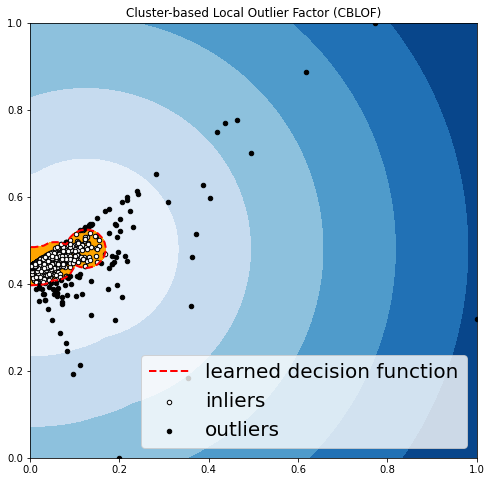

In [61]:
plt.figure(figsize=(8, 8))

df1 = df
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
threshold = percentile(scores_pred, 100 * outliers_fraction)        
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
print(Z)

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Cluster-based Local Outlier Factor (CBLOF)')
plt.show();

<a id='sect2_2'></a>
### <font color='darkgreen'>Histogram-based Outlier Detection (HBOS)</font>
**[HBOS](https://pyod.readthedocs.io/en/latest/pyod.models.html?highlight=HBOS#pyod.models.hbos.HBOS) assumes the feature independence and calculates the degree of anomalies by building histograms.** In multivariate anomaly detection, a histogram for each single feature can be computed, scored individually and combined at the end. When using PyOD library, the code are very similar with the CBLOF.

In [78]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = HBOS(contamination=outliers_fraction)
clf.fit(X)

HBOS(alpha=0.1, contamination=0.01, n_bins=10, tol=0.5)

In [79]:
scores_pred = clf.decision_function(X) * -1
scores_pred

array([6.64311352, 6.64311352, 6.64311352, ..., 6.64311352, 6.64311352,
       6.64311352])

In [80]:
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
print(f"{n_inliers:,d} inliners; {n_outliers:,d} outliners")

9,904 inliners; 90 outliners


OUTLIERS: 90 INLIERS: 9904


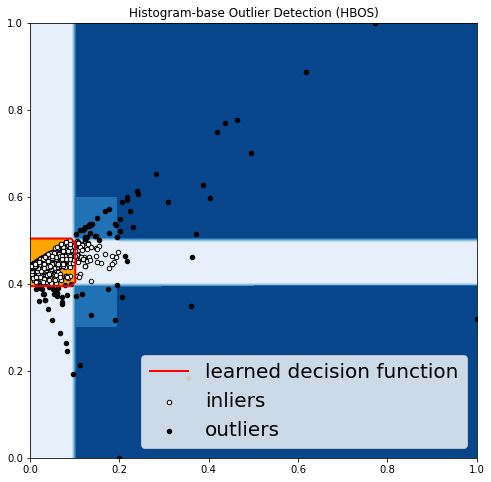

In [81]:
plt.figure(figsize=(8, 8))
# copy of dataframe
df1 = df
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold], linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')  
     
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Histogram-base Outlier Detection (HBOS)')
plt.show();

<a id='sect2_3'></a>
### <font color='darkgreen'>Isolation Forest</font>
[**Isolation Forest**](https://en.wikipedia.org/wiki/Isolation_forest) is similar in principle to Random Forest and is built on the basis of decision trees. Isolation Forest isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of that selected feature.

The [**PyOD Isolation Forest module**](https://pyod.readthedocs.io/en/latest/pyod.models.html?highlight=from%20pyod.models.iforest%20import%20IForest#pyod.models.iforest.IForest) is a wrapper of [**Scikit-learn Isolation Forest**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) with more functionalities.

In [71]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = IForest(contamination=outliers_fraction,random_state=0)
clf.fit(X)

IForest(behaviour='old', bootstrap=False, contamination=0.01,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=0, verbose=0)

In [73]:
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
scores_pred

array([0.32502307, 0.20971645, 0.39812101, ..., 0.33740561, 0.38904877,
       0.3095274 ])

In [74]:
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
print(f"{n_inliers:,d} inliners; {n_outliers:,d} outliners")

9,894 inliners; 100 outliners


OUTLIERS:  100 INLIERS:  9894


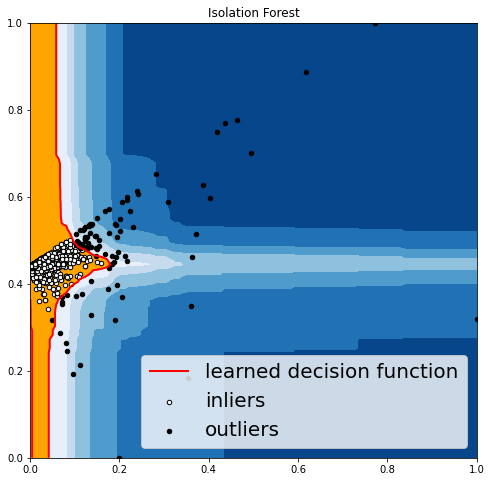

In [75]:
plt.figure(figsize=(8, 8))
# copy of dataframe
df1 = df
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ',n_outliers,'INLIERS: ',n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Isolation Forest')
plt.show();

<a id='sect2_4'></a>
### <font color='darkgreen'>K - Nearest Neighbors (KNN)</font>
KNN is one of the simplest methods in anomaly detection. For a data point, its distance to its kth nearest neighbor could be viewed as the outlier score.

In [84]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = KNN(contamination=outliers_fraction)
clf.fit(X)

KNN(algorithm='auto', contamination=0.01, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [85]:
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
scores_pred

array([-4.12911712e-04, -1.13772945e-03, -0.00000000e+00, ...,
       -2.55352506e-04, -1.28154126e-05, -1.54683608e-04])

In [86]:
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
print(f"{n_inliers:,d} inliners; {n_outliers:,d} outliners")

9,903 inliners; 91 outliners


OUTLIERS:  91 INLIERS:  9903


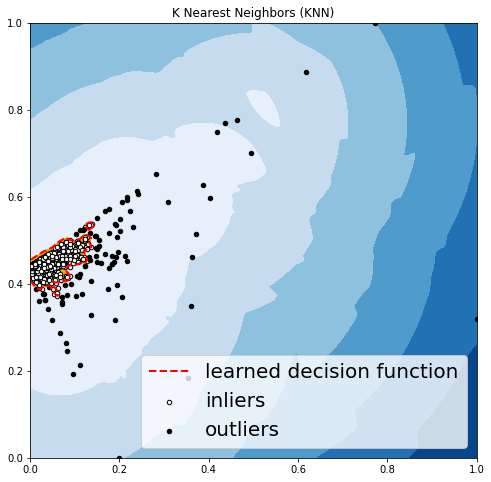

In [87]:
plt.figure(figsize=(8, 8))
# copy of dataframe
df1 = df
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ',n_outliers,'INLIERS: ',n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')  
   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('K Nearest Neighbors (KNN)')
plt.show();

The anomalies predicted by the above four algorithms were not very different.

<a id='sect2_5'></a>
### <font color='darkgreen'>Visually investigate some of the anomalies</font>
We may want to investigate each of the outliers that determined by our model, for example, **let’s look in details for a couple of outliers that determined by KNN, and try to understand what make them anomalies**.

In [88]:
df.iloc[1995]

Row ID                                                        1996
Order ID                                            US-2017-147221
Order Date                                     2017-12-02 00:00:00
Ship Date                                      2017-12-04 00:00:00
Ship Mode                                             Second Class
Customer ID                                               JS-16030
Customer Name                                            Joy Smith
Segment                                                   Consumer
Country                                              United States
City                                                       Houston
State                                                        Texas
Postal Code                                                  77036
Region                                                     Central
Product ID                                         OFF-AP-10002534
Category                                           Office Supp

For this particular order, a customer purchased 5 products with total price at 294.62 and profit at lower than -766, with 80% discount. **It seems like a <font color='darkred'>clearance</font>**. We should be aware of the loss for each product we sell.

In [89]:
df.iloc[9649]

Row ID                                            9650
Order ID                                CA-2016-107104
Order Date                         2016-11-26 00:00:00
Ship Date                          2016-11-30 00:00:00
Ship Mode                               Standard Class
Customer ID                                   MS-17365
Customer Name                      Maribeth Schnelling
Segment                                       Consumer
Country                                  United States
City                                       Los Angeles
State                                       California
Postal Code                                      90045
Region                                            West
Product ID                             FUR-BO-10002213
Category                                     Furniture
Sub-Category                                 Bookcases
Product Name     DMI Eclipse Executive Suite Bookcases
Sales                                         0.150464
Quantity  

For this purchase, it seems to me that the **profit at around 4.7% is too small** and the model determined that this order is an anomaly.

In [90]:
df.iloc[9270]

Row ID                                                 9271
Order ID                                     US-2017-102183
Order Date                              2017-08-21 00:00:00
Ship Date                               2017-08-28 00:00:00
Ship Mode                                    Standard Class
Customer ID                                        PK-19075
Customer Name                                     Pete Kriz
Segment                                            Consumer
Country                                       United States
City                                          New York City
State                                              New York
Postal Code                                           10035
Region                                                 East
Product ID                                  OFF-BI-10001359
Category                                    Office Supplies
Sub-Category                                        Binders
Product Name     GBC DocuBind TL300 Elec

For the above order, a customer **purchased 6 product at 4305 in total price, after 20% discount, we still get over 33% of the profit.** We would love to have more of these kind of anomalies.